<a id='home'></a>
### Contents

[Imports](#Imports)

[Data Preparing](#DataPreparing)

<a id='Imports'></a>
### Imports
[back to contents](#home)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join as p_join
import sys
from collections import Counter
from datetime import datetime
from typing import List, Tuple, Dict, Set, Any, Optional, Callable
from pathlib import Path
sys.path.insert(0, str(Path(os.getcwd()).parent))
import requests
import json
import pickle
from tqdm import tqdm
try:
    from fabulous import color as fb_color
    color_print = lambda x, color='green': print(getattr(fb_color, color)(x)) if 'fb_color' in globals() else print(x)
except Exception as e:
    color_print = lambda x, color='green': print(x)

from bs4 import BeautifulSoup
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 200)

In [4]:
matplotlib.rcParams['figure.figsize'] = (7, 7)
sns.set_style('whitegrid')

In [5]:
# from src.common_utils import get_container_ipaddr
# from src.minio_utils import initialize_minio_client, load_json_from_minio
from src.db_utils import get_pg_engine
from src.common_utils import (
    prepare_date,
    clip_categories,
)

<a id='DataPreparing'></a>
### Data Preparing
[back to contents](#home)

In [6]:
eng = get_pg_engine()

df = pd.read_sql('select * from raw_data.all_fights_info', eng)
print(f'df: {df.shape[0]:,} x {df.shape[1]:,}')
df.head(3)

df: 7,097 x 165


,names__1,names__2,fight_name,method,round,time,timeformat,referee,date,location,event_name,event_uri,fight_uri,winloose_fighter1,winloose_fighter2,per_round_stats__round1__fighter__1,per_round_stats__round1__fighter__2,per_round_stats__round1__kd__1,per_round_stats__round1__kd__2,per_round_stats__round1__sig_str__1,per_round_stats__round1__sig_str__2,per_round_stats__round1__sig_str_perc__1,per_round_stats__round1__sig_str_perc__2,per_round_stats__round1__totalstr__1,per_round_stats__round1__totalstr__2,per_round_stats__round1__td_perc__1,per_round_stats__round1__td_perc__2,per_round_stats__round1__sub_att__1,per_round_stats__round1__sub_att__2,per_round_stats__round1__rev__1,per_round_stats__round1__rev__2,per_round_stats__round1__ctrl__1,per_round_stats__round1__ctrl__2,per_round_stats__round1__head__1,per_round_stats__round1__head__2,per_round_stats__round1__body__1,per_round_stats__round1__body__2,per_round_stats__round1__leg__1,per_round_stats__round1__leg__2,per_round_stats__round1__distance__1,per_round_stats__round1__distance__2,per_round_stats__round1__clinch__1,per_round_stats__round1__clinch__2,per_round_stats__round1__ground__1,per_round_stats__round1__ground__2,per_round_stats__round2__fighter__1,per_round_stats__round2__fighter__2,per_round_stats__round2__kd__1,per_round_stats__round2__kd__2,per_round_stats__round2__sig_str__1,per_round_stats__round2__sig_str__2,per_round_stats__round2__sig_str_perc__1,per_round_stats__round2__sig_str_perc__2,per_round_stats__round2__totalstr__1,per_round_stats__round2__totalstr__2,per_round_stats__round2__td_perc__1,per_round_stats__round2__td_perc__2,per_round_stats__round2__sub_att__1,per_round_stats__round2__sub_att__2,per_round_stats__round2__rev__1,per_round_stats__round2__rev__2,per_round_stats__round2__ctrl__1,per_round_stats__round2__ctrl__2,per_round_stats__round2__head__1,per_round_stats__round2__head__2,per_round_stats__round2__body__1,per_round_stats__round2__body__2,per_round_stats__round2__leg__1,per_round_stats__round2__leg__2,per_round_stats__round2__distance__1,per_round_stats__round2__distance__2,per_round_stats__round2__clinch__1,per_round_stats__round2__clinch__2,per_round_stats__round2__ground__1,per_round_stats__round2__ground__2,per_round_stats__round3__fighter__1,per_round_stats__round3__fighter__2,per_round_stats__round3__kd__1,per_round_stats__round3__kd__2,per_round_stats__round3__sig_str__1,per_round_stats__round3__sig_str__2,per_round_stats__round3__sig_str_perc__1,per_round_stats__round3__sig_str_perc__2,per_round_stats__round3__totalstr__1,per_round_stats__round3__totalstr__2,per_round_stats__round3__td_perc__1,per_round_stats__round3__td_perc__2,per_round_stats__round3__sub_att__1,per_round_stats__round3__sub_att__2,per_round_stats__round3__rev__1,per_round_stats__round3__rev__2,per_round_stats__round3__ctrl__1,per_round_stats__round3__ctrl__2,per_round_stats__round3__head__1,per_round_stats__round3__head__2,per_round_stats__round3__body__1,per_round_stats__round3__body__2,per_round_stats__round3__leg__1,per_round_stats__round3__leg__2,per_round_stats__round3__distance__1,per_round_stats__round3__distance__2,per_round_stats__round3__clinch__1,per_round_stats__round3__clinch__2,per_round_stats__round3__ground__1,per_round_stats__round3__ground__2,per_round_stats__round4__fighter__1,per_round_stats__round4__fighter__2,per_round_stats__round4__kd__1,per_round_stats__round4__kd__2,per_round_stats__round4__sig_str__1,per_round_stats__round4__sig_str__2,per_round_stats__round4__sig_str_perc__1,per_round_stats__round4__sig_str_perc__2,per_round_stats__round4__totalstr__1,per_round_stats__round4__totalstr__2,per_round_stats__round4__td_perc__1,per_round_stats__round4__td_perc__2,per_round_stats__round4__sub_att__1,per_round_stats__round4__sub_att__2,per_round_stats__round4__rev__1,per_round_stats__round4__rev__2,per_round_stats__round4__ctrl__1,per_round_stats__round4__ctrl__2,per_round_stats__round4__head__1,per_round_stats__round4__head__2,per_round_st

In [7]:
df['date_processed'] = prepare_date(date_col=df['date'])
df['date_year_month'] = df['date_processed'].dt.to_period('M')

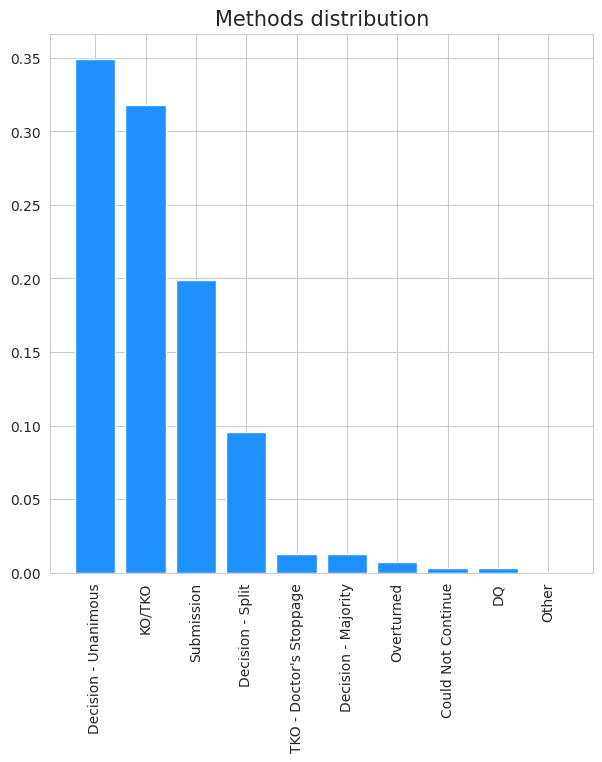

In [8]:
tmp = df['method'].value_counts(1).to_dict()
plt.title('Methods distribution', fontsize=15);
plt.bar(list(tmp.keys()), list(tmp.values()), color='dodgerblue');
plt.tick_params(axis='x', rotation=90);

In [9]:
from src.common_utils import clip_categories

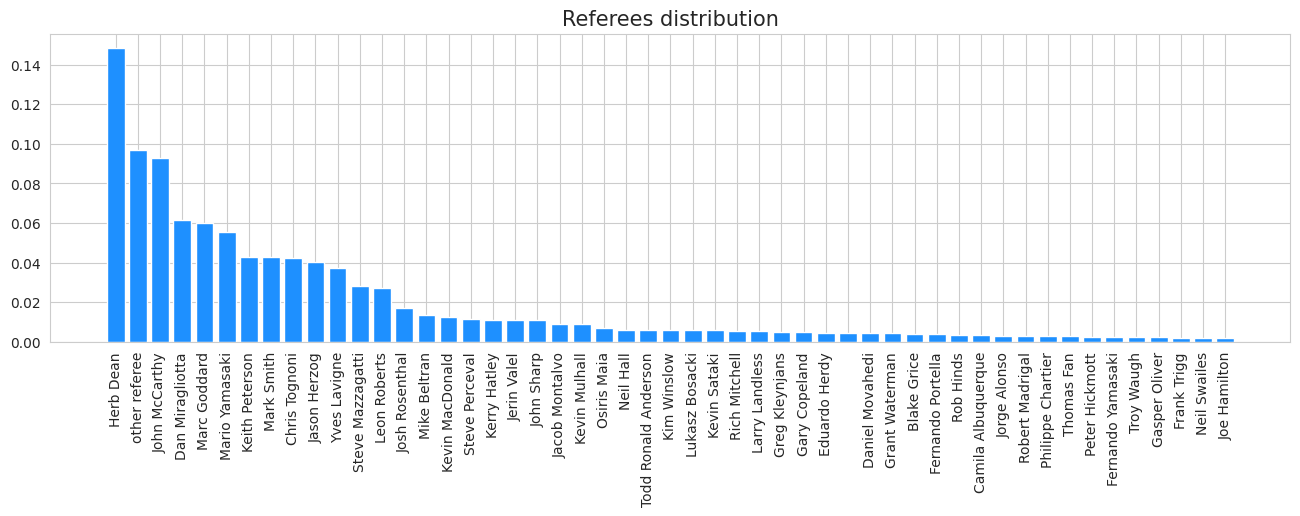

In [10]:
tmp = clip_categories(
    series=df['referee'],
    leave_top_n_categories=50,
    other_category_name='other referee'
)
tmp = tmp.value_counts(1).to_dict()
plt.figure(figsize=(16, 4))
plt.title('Referees distribution', fontsize=15);
plt.bar(list(tmp.keys()), list(tmp.values()), color='dodgerblue');
plt.tick_params(axis='x', rotation=90);

In [11]:
d = datetime.date(df['date_processed'][0])
datetime.date(d.year, d.month // 3 + 1, 1)

TypeError: descriptor 'date' for 'datetime.datetime' objects doesn't apply to a 'int' object

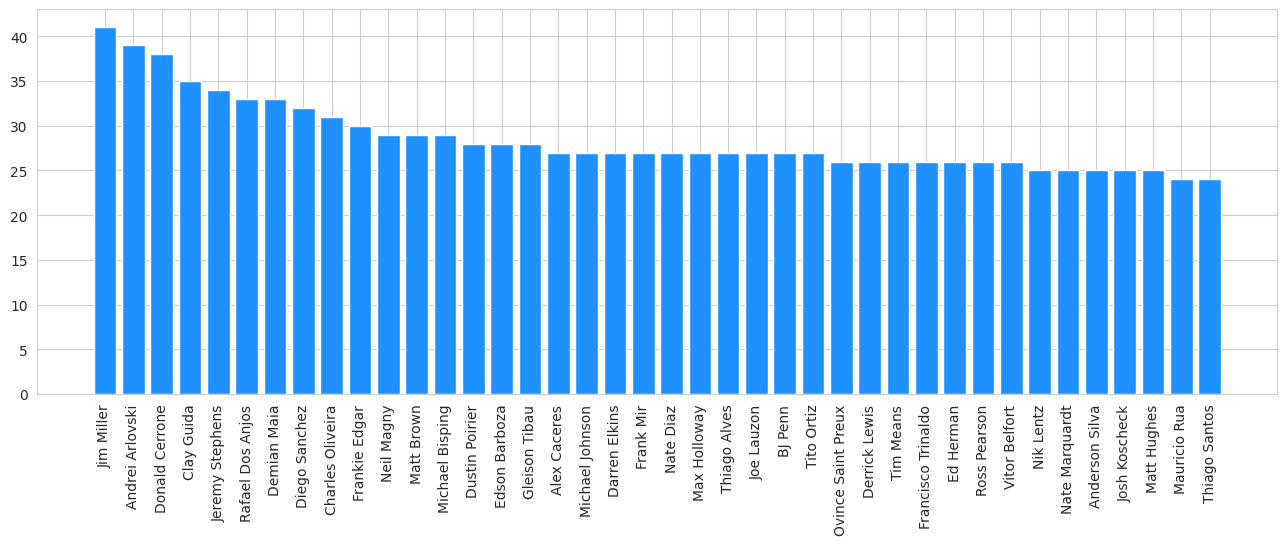

In [12]:
cnt_dict = dict(Counter(df['names__1'].tolist() + df['names__2'].tolist()))
top_k = 40
names, cnts = [], []
for name, cnt in sorted(cnt_dict.items(), key=lambda x: x[1], reverse=True):
    names.append(name)
    cnts.append(cnt)

plt.figure(figsize=(16, 5))
plt.title('Number of fights per fighter', fontsize=15);
plt.title(f'')
plt.bar(names[:top_k], cnts[:top_k], color='dodgerblue')
plt.tick_params(axis='x', rotation=90)

In [13]:
# Number of fights between fighters
df[['names__1', 'names__2']].value_counts()

names__1             names__2         
Deiveson Figueiredo  Brandon Moreno       3
Tito Ortiz           Ken Shamrock         3
Dustin Poirier       Conor McGregor       3
Georges St-Pierre    Matt Hughes          2
Don Frye             Mark Hall            2
                                         ..
Gabriel Benitez      Billy Quarantillo    1
                     Andre Fili           1
Gabe Green           Yohan Lainesse       1
                     Phil Rowe            1
Zubaira Tukhugov     Phillipe Nover       1
Name: count, Length: 6993, dtype: int64

In [14]:
winloose_dict = {}
uniq_decisions = set(['W', 'L', 'D', 'NC'])
for name1, name2, decision1, decision2 in df[
        ['names__1', 'names__2', 'winloose_fighter1', 'winloose_fighter2']
    ].itertuples(index=False):

    if decision1 not in uniq_decisions or decision2 not in uniq_decisions:
        print(f"WARNING! Strange decision decision1={decision1} decision2={decision2}")
    
    if name1 not in winloose_dict:
        winloose_dict[name1] = {'W': 0, 'L': 0, 'D': 0, 'NC': 0}
    if name2 not in winloose_dict:
        winloose_dict[name2] = {'W': 0, 'L': 0, 'D': 0, 'NC': 0}

    winloose_dict[name1][decision1] += 1
    winloose_dict[name2][decision2] += 1

In [15]:
record_df = pd.DataFrame(winloose_dict).T.reset_index().rename(columns={'index': 'fighter'})
record_df['wins_minus_losses'] = record_df['W'] - record_df['L']
record_df.sort_values(by=['wins_minus_losses', 'W', 'L'], ascending=[False, False, True])

,fighter,W,L,D,NC,wins_minus_losses
878,Jon Jones,21,1,0,1,20
1133,Georges St-Pierre,20,2,0,0,18
247,Dustin Poirier,21,6,0,1,15
516,Max Holloway,20,7,0,0,13
424,Kamaru Usman,15,2,0,0,13
...,...,...,...,...,...,...
1382,Naoyuki Kotani,0,5,0,0,-5
1524,Pat Healy,0,5,0,1,-5
1711,John Alessio,0,5,0,0,-5
1097,Joshua Burkman,6,12,0,1,-6


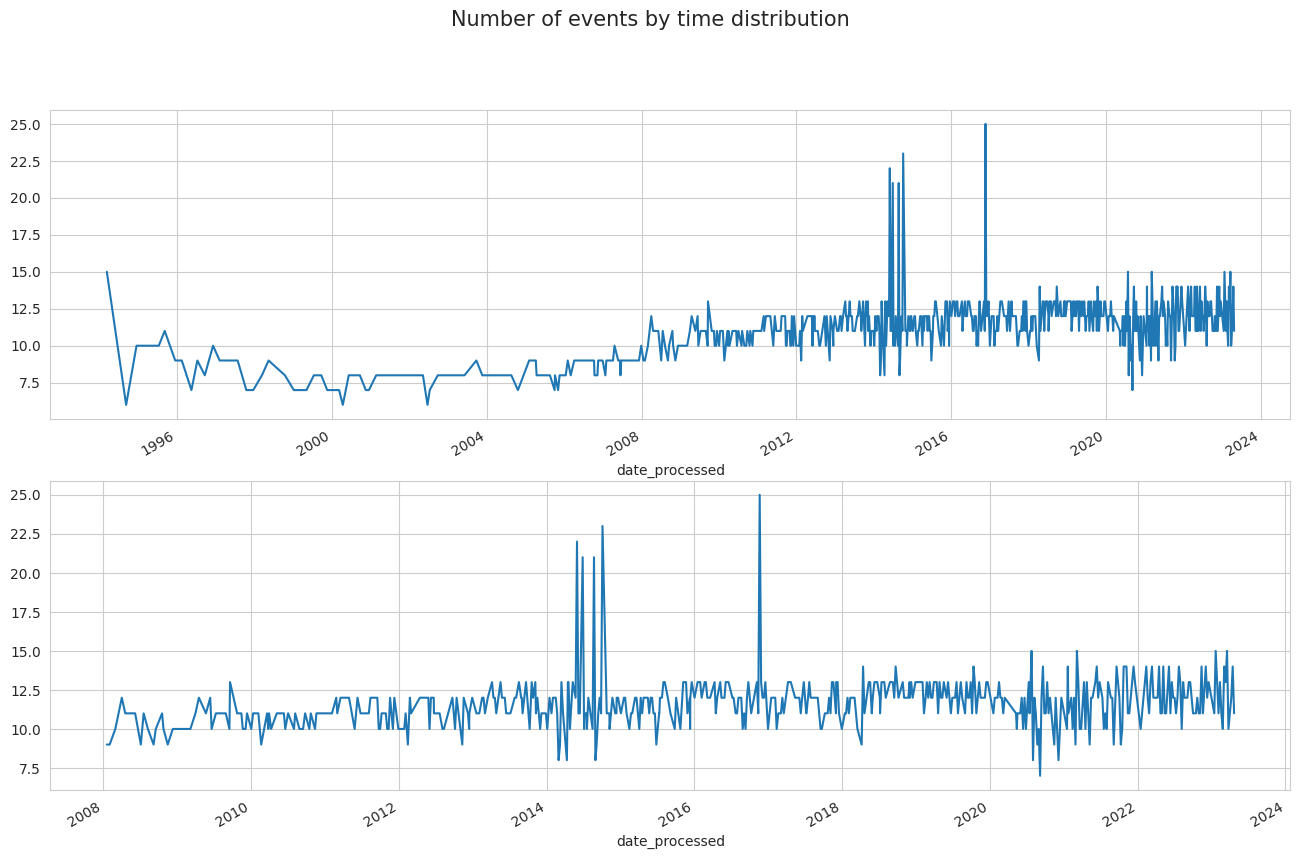

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))
fig.suptitle("Number of events by time distribution", fontsize=15);
df['date_processed'].value_counts().sort_index().plot(kind='line', ax=ax[0])
df['date_processed'][(df['date_processed'] >= datetime(2008, 1, 1))].value_counts().sort_index().plot(kind='line', ax=ax[1]);

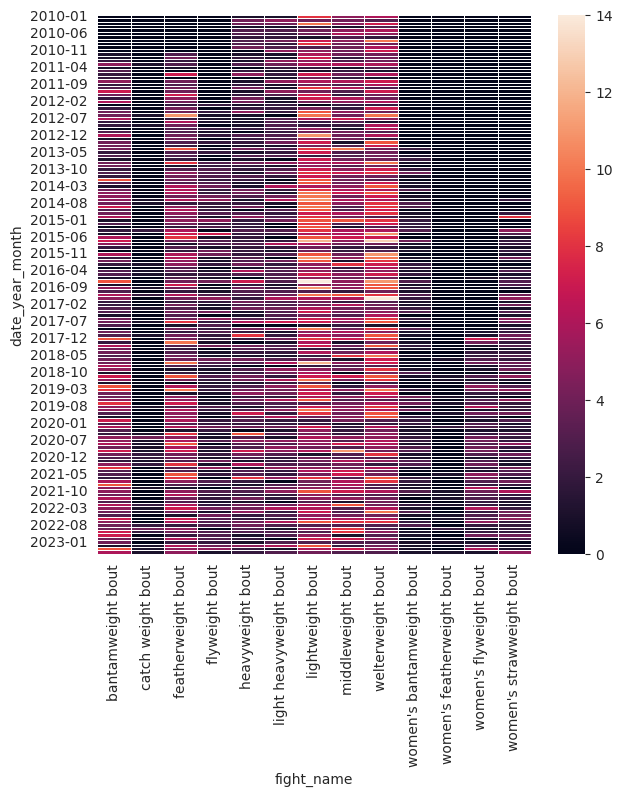

In [18]:
tmp = (
    df.loc[
        (
            df['fight_name'].apply(
                lambda x: (not x.startswith('ufc')) and (not x.startswith('ultimate')) and (not x.startswith('tuf'))
            )
        ) &
        (df['date_processed'] >= datetime(2010, 1, 1))
    ]
    .groupby('date_year_month')
    ['fight_name']
    .value_counts()
    .reset_index()
)

weights_by_month_df = pd.pivot_table(
    data=tmp,
    values='count',
    index='date_year_month',
    columns='fight_name',
    aggfunc=sum,
    fill_value=0,
)
# weights_by_month_df = weights_by_month_df/weights_by_month_df.sum(axis=1)
sns.heatmap(weights_by_month_df, lw=0.5, annot=False);

,names__1,names__2,fight_name,method,round,time,timeformat,referee,date,location,event_name,event_uri,fight_uri,winloose_fighter1,winloose_fighter2,per_round_stats__round1__fighter__1,per_round_stats__round1__fighter__2,per_round_stats__round1__kd__1,per_round_stats__round1__kd__2,per_round_stats__round1__sig_str__1,per_round_stats__round1__sig_str__2,per_round_stats__round1__sig_str_perc__1,per_round_stats__round1__sig_str_perc__2,per_round_stats__round1__totalstr__1,per_round_stats__round1__totalstr__2,per_round_stats__round1__td_perc__1,per_round_stats__round1__td_perc__2,per_round_stats__round1__sub_att__1,per_round_stats__round1__sub_att__2,per_round_stats__round1__rev__1,per_round_stats__round1__rev__2,per_round_stats__round1__ctrl__1,per_round_stats__round1__ctrl__2,per_round_stats__round1__head__1,per_round_stats__round1__head__2,per_round_stats__round1__body__1,per_round_stats__round1__body__2,per_round_stats__round1__leg__1,per_round_stats__round1__leg__2,per_round_stats__round1__distance__1,per_round_stats__round1__distance__2,per_round_stats__round1__clinch__1,per_round_stats__round1__clinch__2,per_round_stats__round1__ground__1,per_round_stats__round1__ground__2,per_round_stats__round2__fighter__1,per_round_stats__round2__fighter__2,per_round_stats__round2__kd__1,per_round_stats__round2__kd__2,per_round_stats__round2__sig_str__1,per_round_stats__round2__sig_str__2,per_round_stats__round2__sig_str_perc__1,per_round_stats__round2__sig_str_perc__2,per_round_stats__round2__totalstr__1,per_round_stats__round2__totalstr__2,per_round_stats__round2__td_perc__1,per_round_stats__round2__td_perc__2,per_round_stats__round2__sub_att__1,per_round_stats__round2__sub_att__2,per_round_stats__round2__rev__1,per_round_stats__round2__rev__2,per_round_stats__round2__ctrl__1,per_round_stats__round2__ctrl__2,per_round_stats__round2__head__1,per_round_stats__round2__head__2,per_round_stats__round2__body__1,per_round_stats__round2__body__2,per_round_stats__round2__leg__1,per_round_stats__round2__leg__2,per_round_stats__round2__distance__1,per_round_stats__round2__distance__2,per_round_stats__round2__clinch__1,per_round_stats__round2__clinch__2,per_round_stats__round2__ground__1,per_round_stats__round2__ground__2,per_round_stats__round3__fighter__1,per_round_stats__round3__fighter__2,per_round_stats__round3__kd__1,per_round_stats__round3__kd__2,per_round_stats__round3__sig_str__1,per_round_stats__round3__sig_str__2,per_round_stats__round3__sig_str_perc__1,per_round_stats__round3__sig_str_perc__2,per_round_stats__round3__totalstr__1,per_round_stats__round3__totalstr__2,per_round_stats__round3__td_perc__1,per_round_stats__round3__td_perc__2,per_round_stats__round3__sub_att__1,per_round_stats__round3__sub_att__2,per_round_stats__round3__rev__1,per_round_stats__round3__rev__2,per_round_stats__round3__ctrl__1,per_round_stats__round3__ctrl__2,per_round_stats__round3__head__1,per_round_stats__round3__head__2,per_round_stats__round3__body__1,per_round_stats__round3__body__2,per_round_stats__round3__leg__1,per_round_stats__round3__leg__2,per_round_stats__round3__distance__1,per_round_stats__round3__distance__2,per_round_stats__round3__clinch__1,per_round_stats__round3__clinch__2,per_round_stats__round3__ground__1,per_round_stats__round3__ground__2,per_round_stats__round4__fighter__1,per_round_stats__round4__fighter__2,per_round_stats__round4__kd__1,per_round_stats__round4__kd__2,per_round_stats__round4__sig_str__1,per_round_stats__round4__sig_str__2,per_round_stats__round4__sig_str_perc__1,per_round_stats__round4__sig_str_perc__2,per_round_stats__round4__totalstr__1,per_round_stats__round4__totalstr__2,per_round_stats__round4__td_perc__1,per_round_stats__round4__td_perc__2,per_round_stats__round4__sub_att__1,per_round_stats__round4__sub_att__2,per_round_stats__round4__rev__1,per_round_stats__round4__rev__2,per_round_stats__round4__ctrl__1,per_round_stats__round4__ctrl__2,per_round_stats__round4__head__1,per_round_stats__round4__head__2,per_round_st